# Pole-zero correction

In [1]:
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as sco
from pprint import pprint
import tinydb as db
from tinydb.storages import MemoryStorage
import pdb
import pygama.math.utils as pgu
from itertools import compress



from scipy.optimize import curve_fit
def exp_decay_func(x,A,tau,C):
    return A*np.exp(-x/tau)+C

from scipy.stats import norm

import matplotlib
# matplotlib.use('Agg') # when running on cori
import matplotlib.pyplot as plt
plt.style.use('/global/u2/f/fnafis/nfuad.mpl')
#plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm


from pygama.vis.waveform_browser import WaveformBrowser as wfb

from pygama.flow import DataGroup
import pygama.lgdo.lh5_store as lh5
import pygama.math.histogram as pgh
#import pygama.analysis.peak_fitting as pgf
#import psd_analysis as psd

#import calibration_jdetwiler as cb


dg = DataGroup('/global/homes/f/fnafis/krstc/krstc.json', load=True)
    
fontsize = 20  
def draw_canvas(plt, fontsize=fontsize, xlabel='xlabel', ylabel='count', title='title'):
    plt.figure(figsize=(20,16))
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize*1.5)
    plt.ylabel(ylabel, fontsize=fontsize*1.5)
    plt.legend(fontsize=fontsize)
    plt.title(title, fontsize=fontsize*2)
    
beginning_cycle = 2019
#cycle_range = [2028,2029, 'bkg', 'run2'] #run 2
cycle_range = [2039,2045, 'kr', 'run3'] #run 3
#cycle_range = [2028,2029, 'Run2'] #run 7


lh5_dir = dg.lh5_dir
dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']


hit_list = dsp_list[cycle_range[0]-beginning_cycle:cycle_range[1]-beginning_cycle]

#hit_list = dsp_list[2039-2019]
'''
columns in file:
        ['trapE', 'bl', 'bl_sig', 'A_10', 'AoE', 'packet_id', 'ievt', 'energy',
        'energy_first', 'timestamp', 'crate', 'card', 'channel', 'energy_cal',
        'trapE_cal']'''


df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'bl', 'A_10', 'timestamp'], 'ORSIS3302DecoderForEnergy/dsp')
#timestamp is in unit of 10ns.
#current_pars = [0.4494, 0.1825]
current_pars = [0.430, -0.09979]
df_hit['trapEmax_cal'] = np.polyval(current_pars, df_hit['trapEmax'])


#getting raw files, for wfs
raw_files = []
tb_name_raw = 'ORSIS3302DecoderForEnergy/raw'
for cycle in range(cycle_range[0],cycle_range[1]):
    raw_files.append('/global/cfs/cdirs/legend/data/krstc/LH5/raw/krstc_'+cycle_range[3]+'_cyc'+str(cycle)+'_raw.lh5')




In [5]:
df_hit['dt'] = 0.0
df_hit['dt'] = df_hit['timestamp'].diff()
df_hit

,trapEmax,bl,A_10,timestamp,trapEmax_cal,dt
0,2912.978027,58088.734375,279.459747,5019890,1252.480835,NaN
1,281.967651,58090.820312,27.024261,6496549,121.146301,1476659.0
2,6090.773926,58089.191406,571.791016,8347318,2618.932861,1850769.0
3,890.816528,58088.488281,85.550591,9045359,382.951324,698041.0
4,442.672150,58088.519531,42.486481,10068139,190.249237,1022780.0
...,...,...,...,...,...,...
731501,744.822388,58090.902344,69.304443,155908689091,320.173828,170508.0
731502,86.567940,58093.773438,8.325802,155909777992,37.124428,1088901.0
731503,2679.190918,58092.664062,252.132965,155912616837,1151.952393,2838845.0
731504,145.561478,58088.804688,14.111674,155914120245,62.491650,1503408.0


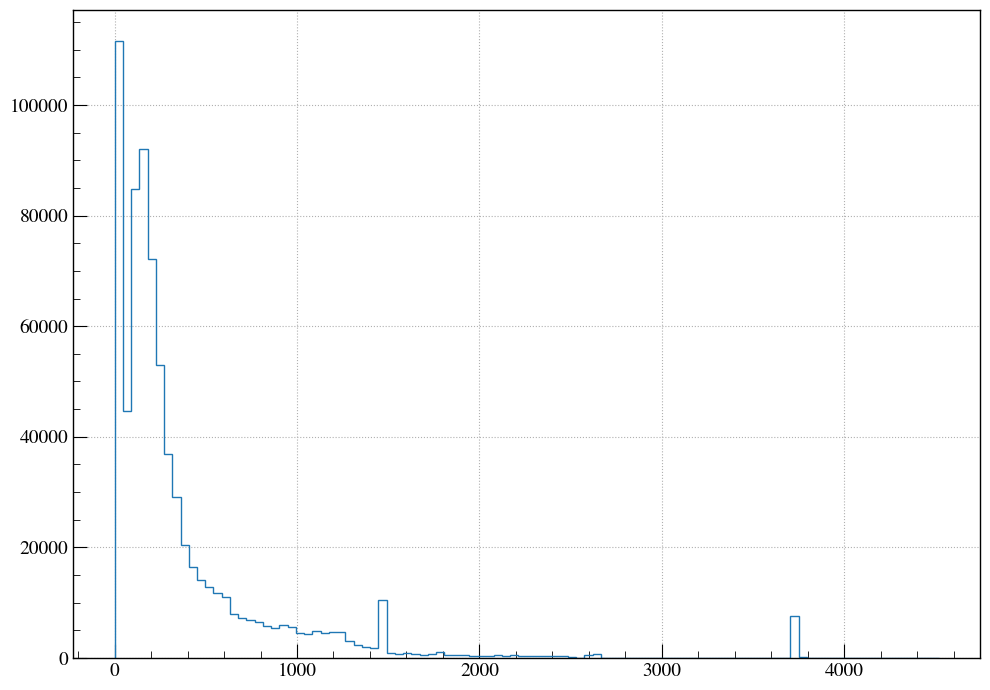

In [3]:
a = plt.hist(df_hit['trapEmax_cal'], bins=100, histtype='step')

In [4]:

bl_range = [58000,58200, 'ADC']
e_cal_range = [225,229, 'keV']


bl_cut =(df_hit['bl']>=bl_range[0]) & (df_hit['bl']<bl_range[1]) 

ene_cut = (df_hit['trapEmax_cal']>e_cal_range[0]) & (df_hit['trapEmax_cal']<e_cal_range[1])

cut = bl_cut & ene_cut
print(cut.sum())

legend = ['{trapEmax},{bl}']

wf_browser = wfb(raw_files, tb_name_raw, 
                dsp_config=os.path.expandvars('$HOME/KrSTC/data/meta/dsp_04_nfuad.json'),
                lines=['wf_blsub'], 
                #waveforms=['wf_pz','wf_trap', 'wf_blsub'],
                x_unit='us',
                #entry_mask = cut,
                #n_drawn = 1
                #x_lim=(38,42)
                legend=legend
                )

nwfs = 1
cut_indices = list(compress(list(range(len(cut))),cut))
entries = np.random.choice(cut_indices, size=nwfs).tolist() #randomly chosen nwfs events
#entries = list(range(nwfs)) #first nwfs events
print(entries)
wf_browser.draw_entry(entries) #how do I get the wfs without plotting them? ans: use wf_browser.find_entry(entries)
plt.ylabel('ADC')

wf = wf_browser.lines['wf_blsub'][0].get_ydata()
time = wf_browser.lines['wf_blsub'][0].get_xdata()

5362


UnsupportedError: Failed in object mode pipeline (step: analyzing bytecode)
[1mAn unsupported bytecode sequence has been encountered: op_LIST_EXTEND at the start of a block.

This could be due to the use of a branch in a tuple unpacking statement.[0m

[878.11303183  76.00134907 -18.84493175]


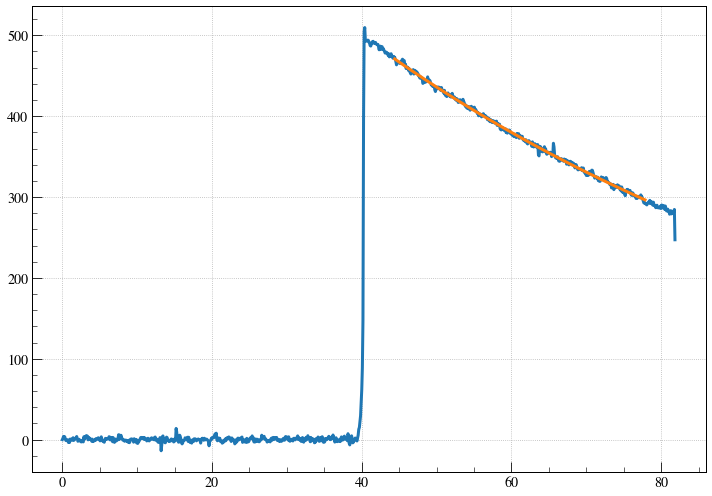

In [ ]:
start_index = np.argmax(wf)+50
end_index = len(wf)-50
wf_to_fit = wf[start_index:end_index]
time_to_fit = time[start_index:end_index]
pars, covs = curve_fit(exp_decay_func, time_to_fit, wf_to_fit, p0=[50,50,0])
plt.plot(time, wf)
y = exp_decay_func(time_to_fit, pars[0], pars[1], pars[2])
plt.plot(time_to_fit, y)
print(pars)

(58040.0, 58100.0)

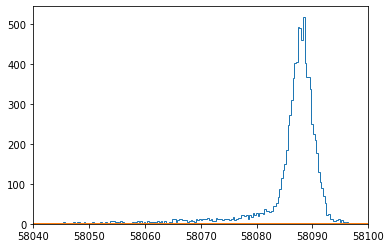

In [ ]:
a = plt.hist(x,range=(58040,58100), bins=int(N/50), histtype='step')
b = plt.plot(x, norm.pdf(x, mean, sigma))*N
plt.xlim(58040,58100)

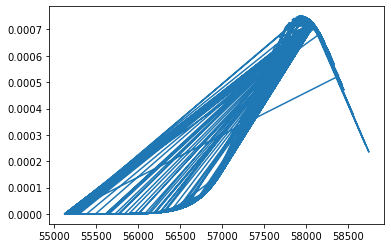

In [ ]:
plt.plot(x, norm.pdf(x, mean, sigma))

In [ ]:
mean, sigma = norm.fit(x)
print(mean,sigma)

57932.35 531.79114


In [ ]:
norm.pdf(x, mean, sigma)

array([0.00071844, 0.00071761, 0.00071826, ..., 0.00071785, 0.00072199,
       0.00072652])

In [ ]:
def exp_decay_func(x,A,tau, C):
    return A*np.exp(-x/tau)+C

raw_list = dg.lh5_dir + dg.fileDB['raw_path']+'/'+dg.fileDB['raw_file']
f_raw = raw_list[9]
print(f_raw)
raw_store = lh5.LH5Store()
tb_name = 'ORSIS3302DecoderForEnergy/raw'
data_raw, nrows = raw_store.read_object(tb_name, f_raw)
bulk_wfs = data_raw['waveform']['values'].nda

params= []
n_wfs = len(bulk_wfs)
n_wfs = 5000

for i in range(n_wfs):
    if i%500==0: print(i/500*100,'%')
    wf = bulk_wfs[i]
    clockticks = np.arange(0, bulk_wfs.shape[1], 1)
    time = clockticks/100 #in us
    #draw_canvas(plt, xlabel='time (us)', ylabel='ADC')
    #plt.plot(time, wf, label='raw wf')

    max_index = np.argmax(wf)+200
    last_index = len(wf)-100
    extra = 3000
    decay_part_of_wf = wf[max_index:last_index]
    decay_part_of_time = time[max_index:last_index+1]
    #len(decay_part_of_wf)


    #pars, covs = pgf.fit_hist(exp_decay_func, decay_part_of_wf, decay_part_of_time, guess = (50,50, 58080))
    try: 
        pars, covs = sco.curve_fit(exp_decay_func, decay_part_of_time[:-1], decay_part_of_wf, p0=[50,50, 58080])
        params.append(pars)
    except:
        params.append(None)
print(np.average(params[0]))
#plt.plot(decay_part_of_time, pars[0]*np.exp(-decay_part_of_time/pars[1])+pars[2], color='r', 
         #linewidth=3, label='scipy curve fit')
#plt.legend(fontsize=fontsize)


/global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run2_cyc2028_raw.lh5
0.0 %


/tmp/ipykernel_40025/3464532142.py:2: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-x/tau)+C


100.0 %
200.0 %
300.0 %


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


400.0 %
500.0 %
600.0 %


/tmp/ipykernel_40025/3464532142.py:2: RuntimeWarning: overflow encountered in multiply
  return A*np.exp(-x/tau)+C


700.0 %
800.0 %
900.0 %


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [ ]:
params[0][2]

58096.13449968061

In [ ]:
np.average(params[:][0])

19415.894255530013

0.0 %


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


4.098427843079395 %


/tmp/ipykernel_21484/3092413362.py:2: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-x/tau)+C


8.19685568615879 %
12.295283529238183 %
16.39371137231758 %


/tmp/ipykernel_21484/3092413362.py:2: RuntimeWarning: overflow encountered in multiply
  return A*np.exp(-x/tau)+C


20.492139215396975 %
24.590567058476367 %
28.688994901555766 %
32.78742274463516 %
36.88585058771455 %
40.98427843079395 %
45.08270627387334 %
49.181134116952734 %
53.279561960032126 %
57.37798980311153 %
61.47641764619092 %
65.57484548927032 %
69.67327333234971 %
73.7717011754291 %
77.8701290185085 %
81.9685568615879 %
86.06698470466729 %
90.16541254774668 %
94.26384039082608 %
98.36226823390547 %


No handles with labels found to put in legend.


(-100.0, 100.0)

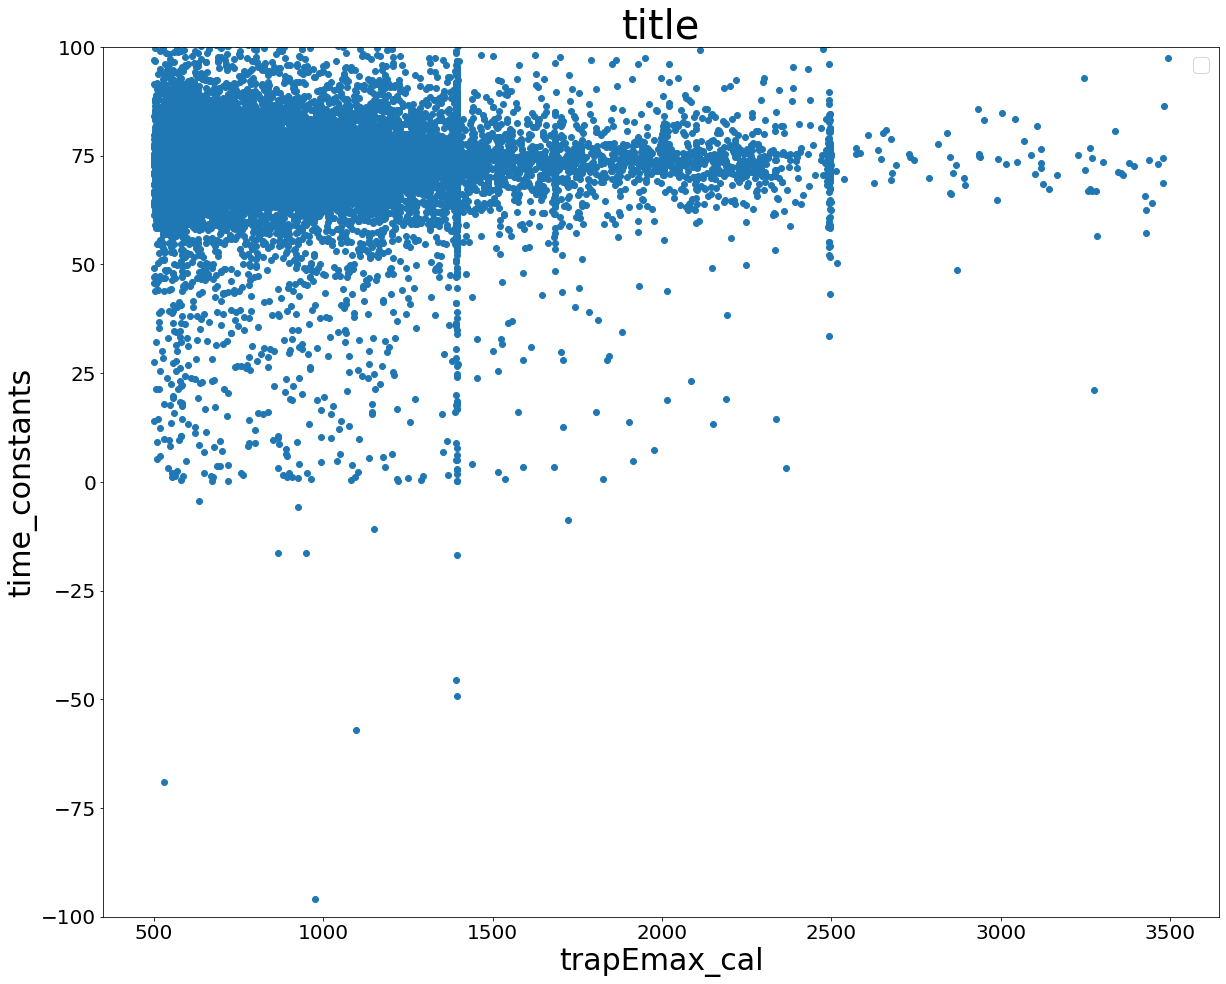

In [ ]:
time_constants = []
trapEmax_cals = []
for i in range(len(bulk_wfs)):
    if i%5000==0: print(i/len(bulk_wfs)*100,'%')
    trapEmax_cal = df_hit['trapEmax_cal'][i]
    if (trapEmax_cal>500 and trapEmax_cal<3500):
        try:

            wf = bulk_wfs[i]
            clockticks = np.arange(0, bulk_wfs.shape[1], 1)
            time = clockticks/100
            max_index = np.argmax(wf)+200
            last_index = len(wf)-200
            extra = 3000
            decay_part_of_wf = wf[max_index:last_index]
            decay_part_of_time = time[max_index:last_index+1]



            #pars, covs = pgf.fit_hist(exp_decay_func, decay_part_of_wf, decay_part_of_time, guess = (50,50, 58080))
            pars, covs = sco.curve_fit(exp_decay_func, decay_part_of_time[:-1], decay_part_of_wf, p0=[50,50, 58080])


            #print(pars)
            time_constants.append(pars[1])
            trapEmax_cals.append(trapEmax_cal)


            #print(trapEmax_cals[i],time_constants[i])

        except:
            pass


    #plt.plot(decay_part_of_time, pars[0]*np.exp(-decay_part_of_time/pars[1])+pars[2], color='r')
draw_canvas(plt, xlabel='trapEmax_cal',ylabel='time_constants')
plt.plot(trapEmax_cals,time_constants, linestyle='None', marker='o')
plt.ylim(-100,100)


In [ ]:
len(trapEmax_cals)

In [ ]:
for i in range(len(time_constants)):
    tc = time_constants[i]
    if (tc<0 or tc>200):
        time_constants.pop(i)
        trapEmax_cals.pop(i)

In [ ]:
np.sqrt(np.diag(covs))

In [ ]:
#time_constants = [tc for tc in time_constants if tc>0 and tc<200] #getting rid of obviously wrong time constants


hist, bins, var = pgh.get_hist(time_constants, bins=500)

max_index = np.argmax(hist)
res = 10 #range_each_side
tc_fit_low = max_index-res
tc_fit_high = max_index+res

draw_canvas(plt,xlabel='time constant (us)', title='Cycle 2028')
pgh.plot_hist(hist,bins)

pars, covs = pgf.fit_hist(pgf.gauss_basic, hist[tc_fit_low:tc_fit_high], bins[tc_fit_low:tc_fit_high+1], guess=[75,3, max(hist)])   
print('gaussian fit pars: ',pars)

pgu.plot_func(pgf.gauss_basic, pars, color='r')
#bin_centers_to_plot_func = pgh.get_bin_centers(bins[tc_fit_low:tc_fit_high])
#plt.plot(bin_centers_to_plot_func, np.polyval(pars,bin_centers_to_plot_func))

In [ ]:
print(len(time_constants))
print(len(trapEmax_cals))

In [ ]:
draw_canvas(plt, xlabel='trapEmax_cal',ylabel='time_constants')
plt.plot(trapEmax_cals,time_constants, linestyle='None', marker='o')

lin_pars = np.polyfit(trapEmax_cals, time_constants, deg=1)
print(lin_pars)

x=np.arange(500,2000,1)
y=np.polyval(lin_pars, x)
plt.plot(x,y,color='r')

plt.ylim(0,200)

### pole zero constants, CAGE

In [ ]:
import pygama.utils_nfuad as unf
import pygama.math_nfuad as mnf


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import copy
import time as t
from scipy import stats
import scipy



filename = '/global/cfs/cdirs/m2676/data/cage/LH5/dsp/cage_run394_cyc2618_dsp.lh5'
raw_filename = '/global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run394_cyc2618_raw.lh5'

6.0


6.3475153918498055

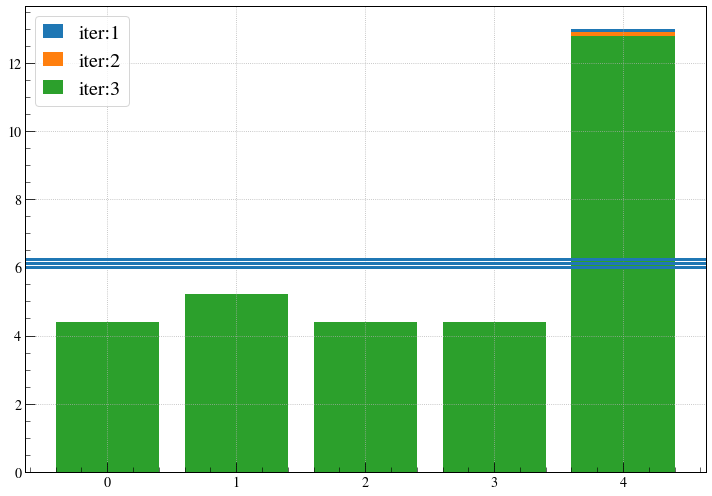

In [ ]:
a = [4,5,4,4,13]
print(np.mean(a))
mnf.pmean(a, deg=3, plot=True)

In [ ]:
nwfs = 10
#indices = pd.Series([20009, 20043, 20059])
trapEmaxs = unf.get_dsp_vals(filename, param='trapEmax',
                             nwfs=nwfs, random=True)
                             #indices=indices)
#print('trapEmax len: ', len(trapEmaxs))
wfs = unf.get_raw_wfs(raw_filename, 
                      indices=trapEmaxs['dsp_file_index'])


df = pd.concat([trapEmaxs,wfs], axis=1)


df

#sys.getsizeof(df)/1024

Unit: ADC


,dsp_file_index,trapEmax,raw_file_index,raw_waveforms
2,2285,2410.084961,2285,"[9291, 9291, 9292, 9288, 9287, 9286, 9288, 928..."
1,2389,493.896576,2389,"[9295, 9289, 9290, 9289, 9291, 9289, 9295, 928..."
6,2813,205.914017,2813,"[9288, 9297, 9287, 9289, 9293, 9293, 9285, 928..."
0,3372,178.404190,3372,"[9290, 9291, 9293, 9290, 9290, 9290, 9293, 929..."
5,5876,857.004150,5876,"[9283, 9286, 9283, 9281, 9287, 9284, 9289, 928..."
3,6062,188.304611,6062,"[9291, 9290, 9293, 9294, 9291, 9284, 9288, 929..."
7,8064,735.005920,8064,"[9293, 9288, 9285, 9284, 9286, 9289, 9283, 928..."
4,8371,858.214722,8371,"[9296, 9291, 9294, 9288, 9293, 9287, 9295, 929..."
8,9820,254.681244,9820,"[9285, 9282, 9286, 9281, 9287, 9286, 9291, 927..."
9,9885,408.337219,9885,"[9289, 9292, 9292, 9294, 9294, 9297, 9295, 929..."


In [ ]:
a = np.random.normal(loc=0, scale=1,size=10)
mnf.pmean_optimized(a)

0.2712504168458049

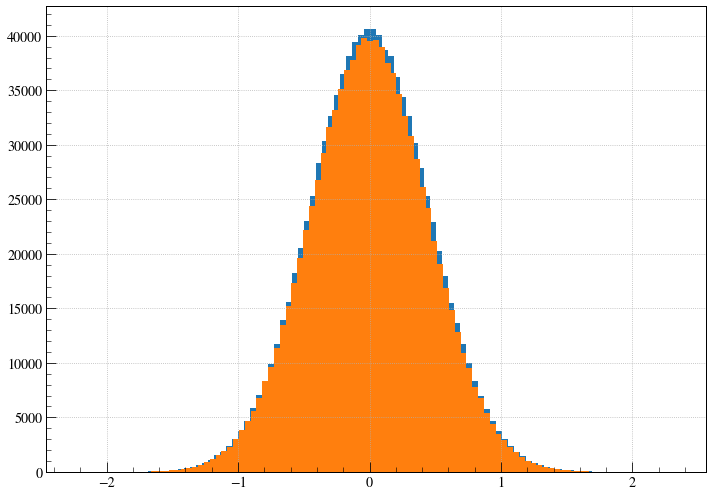

In [ ]:
pmeans = []
means = []
for _ in range(1000000):
    a = np.random.normal(loc=0, scale=1,size=5)
    means.append(np.mean(a))
    pmeans.append(mnf.pmean(a))
n =plt.hist(pmeans, bins=100)
m = plt.hist(means, bins=100)

In [ ]:
for pmean in pmeans:
    if pmean>1e50:
        print(pmean)

8.746513223066716e+86
1.1089303712697833e+55
3.260051408802945e+58
1.3246314345722136e+64
1.7183445386355255e+50
1.9871155635377802e+88
4.555782380541982e+94
2.4850459166755095e+55
3.8139457983608314e+67
1.4125278690251094e+58
1.5490855568077213e+62
1.5353458618685804e+76
3.999222161077901e+75
2.4941536762130607e+57
4.2908070893524705e+60
5.503161357366205e+120
3.9088509557582264e+54
3.4690713869478895e+50
9.047425359867446e+55
1.0507743383252284e+50
8.623781620552008e+85
3.485195987805884e+56
4.6754070656160995e+53
1.843786690336446e+53
1.3619810693240293e+53


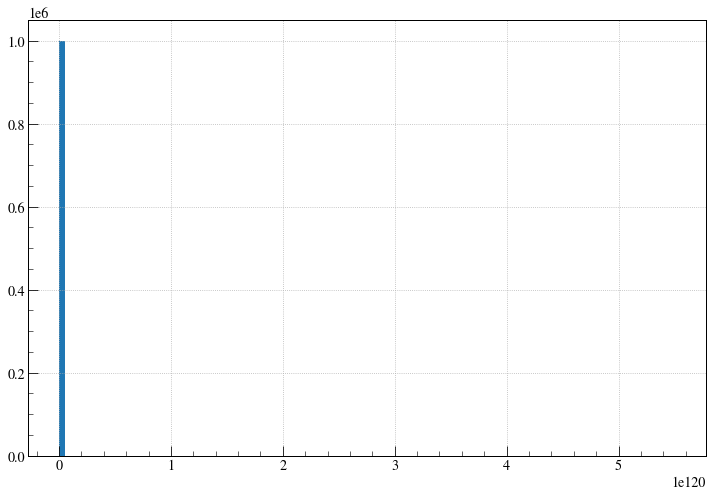

In [ ]:
b = plt.hist(pmeans, bins=100)

central_tendencey: value, time/time_mean
----------------------------------------
mean: 9291.75 ,  1.0
median: 9291.5 ,  8.150627615062762
mode: 9292 ,  13.581589958158995
meadiode: 9291.75 ,  33.27196652719665
pmean: 9291.541756299952 ,  37.06276150627615
gfit_mu: 9291.303852968846 ,  37.54811715481171


9291.541756299952

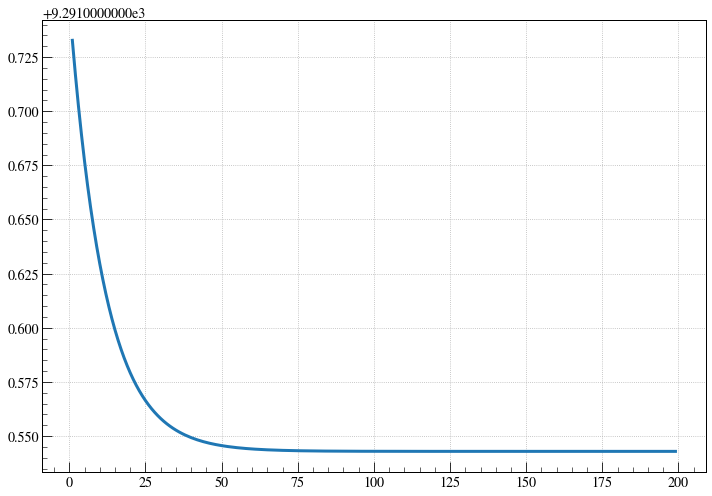

In [ ]:
wf = df.raw_waveforms[4][100:200]
mnf.pmean_optimized(wf, max_deg=50, assymptote=True, comparison=True)

TypeError: '<=' not supported between instances of 'float' and 'NoneType'

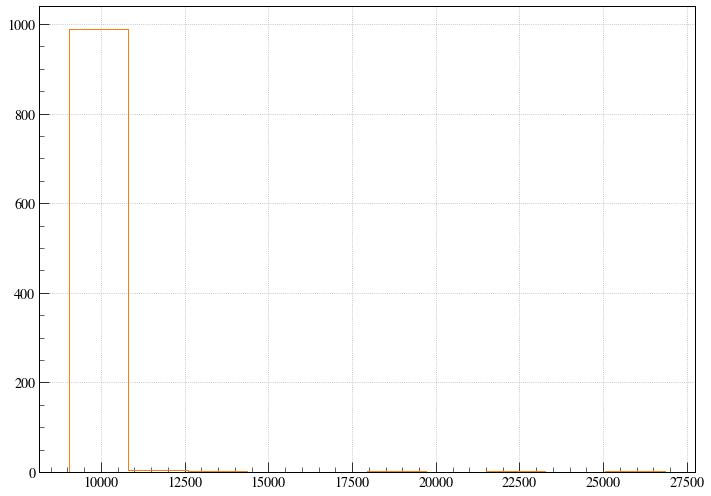

In [ ]:
means, medians, modes, pmeans, gfit_mus = [],[],[],[],[]
t_means, t_medians, t_modes, t_pmeans, t_gfit_mus = [],[],[],[],[]

start_index = 100
end_index = 200

for wf in df.raw_waveforms:
    s = t.time()
    mean = np.mean(wf)
    e = t.time()
    t_mean = e-s
    means.append(mean)
    t_means.append(t_mean/t_mean)
    
    
    s = t.time()
    median = np.median(wf)
    e = t.time()
    medians.append(median)
    t_medians.append((e-s)/t_mean)
    
    s = t.time()
    mode = stats.mode(wf)[0][0]
    e = t.time()
    modes.append(mode)
    t_modes.append((e-s)/t_mean)
    
    
    s = t.time()
    pmean = mnf.pmean_optimized(wf, max_deg=200)
    e = t.time()
    pmeans.append(pmean)
    t_pmeans.append((e-s)/t_mean)
    
    s = t.time()
    gfit_mu = mnf.gaussian_fit(wf)
    e = t.time()
    gfit_mus.append(gfit_mu)
    t_gfit_mus.append((e-s)/t_mean)
    
    
plt.hist(means, histtype='step', label='mean')
plt.hist(pmeans,histtype='step', label='pmean')
plt.hist(gfit_mus,histtype='step', label='gfit_mu')
plt.legend()

central_tendencey: value, time/time_mean
----------------------------------------
mean: 6.875 ,  1.0
median: 8.0 ,  3.9669811320754715
mode: 8 ,  6.636792452830188
meadiode: 7.625 ,  24.61320754716981
pmean: 7.765214128412626 ,  53.589622641509436
gfit_mu: None ,  248.50471698113208


7.765214128412626

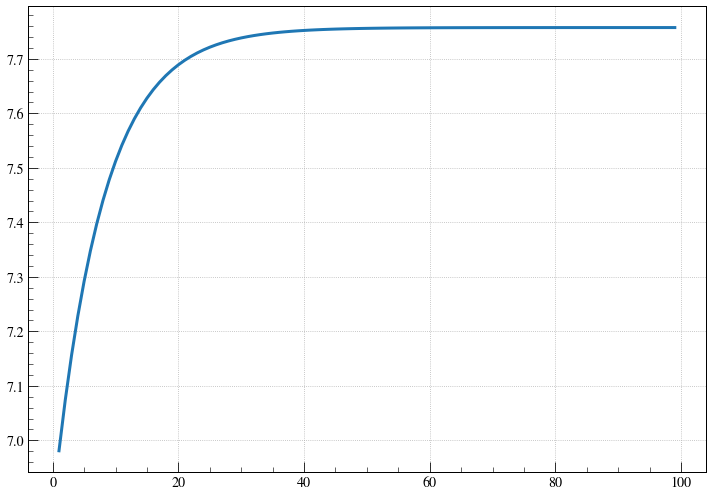

In [ ]:
a = [0,7,8,8,8,8,7,9]
mnf.pmean_optimized(a, assymptote=True, comparison=True)

In [ ]:
pz_consts = []
wfs_pz = []

beginning_padding = 0

for index, row in df.iterrows():
    wf = row['raw_waveforms']
    
    bl = unf.bl(wf)
    #wf_blsub = unf.get_bl_subtracted_wf(wf)
    pz_const = unf.get_pole_zero_consts(wf, plot=False, 
                                        extra_padding_at_beginning=beginning_padding)
    pz_consts.append(pz_const)
    
    
pz_consts_df = pd.DataFrame(pz_consts)

df[['A','tau','C','err_on_A','err_on_tau','err_on_C']] = pz_consts_df
#df = pd.concat([df,pz_consts_df], axis=1, verify_integrity=True)

df


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,dsp_file_index,trapEmax,raw_file_index,raw_waveforms,A,tau,C,err_on_A,err_on_tau,err_on_C
75,5,696.724182,5,"[9296, 9308, 9309, 9301, 9287, 9274, 9271, 926...",1463.825516,38898.106064,9519.302527,2.407590,111.860566,2.614635
2,168,299.905640,168,"[9299, 9294, 9291, 9293, 9303, 9297, 9300, 929...",752.824288,42006.202126,9373.172625,2.730541,255.311713,2.933857
93,334,857.605042,334,"[9290, 9279, 9282, 9289, 9292, 9304, 9308, 931...",384.893997,38047.966724,9362.313453,2.342288,410.293229,2.552523
23,486,273.851990,486,"[9287, 9280, 9290, 9283, 9283, 9288, 9292, 929...",447.503705,40080.963870,9351.265747,2.349128,360.836040,2.538634
45,520,402.305267,520,"[9299, 9291, 9292, 9296, 9298, 9302, 9300, 929...",241.181199,52256.839895,9276.048049,4.232160,1383.444825,4.439017
...,...,...,...,...,...,...,...,...,...,...
1,9592,363.258362,9592,"[9293, 9295, 9290, 9289, 9291, 9293, 9285, 929...",259.040407,39876.268634,9325.524734,2.154954,574.152983,2.334206
12,9829,587.739197,9829,"[9278, 9273, 9280, 9280, 9282, 9284, 9294, 928...",415.900893,41840.772101,9334.355724,2.484990,420.180571,2.671987
39,9861,859.211060,9861,"[9288, 9285, 9293, 9297, 9289, 9298, 9294, 929...",215.870336,30753.293032,9348.011950,1.399642,406.062252,1.584020
79,9972,855.153381,9972,"[9283, 9280, 9284, 9289, 9289, 9288, 9291, 928...",134.394424,33865.332344,9321.976397,1.699300,822.600332,1.892303


In [ ]:
#tau_cut = ~df.tau>np.percentile(df.tau,95)
tau_cut = (df.tau<1e5) & (df.tau>0)
A = np.mean(df.A[tau_cut])
tau = np.mean(df.tau[tau_cut])
C = np.mean(df.C[tau_cut])
pz_const = {'A':A, 'tau':tau, 'C':C}
print(pz_const)

wfs_pz = []
for wf in df.raw_waveforms:
    wf_pz = unf.get_pole_zero_corrected_wf(wf, pz_const, plot=False)
    wfs_pz.append(wf_pz)
    
df['wfs_pz'] =wfs_pz
df

{'A': 729.2238926974177, 'tau': 40992.11284480434, 'C': 9390.316068674507}


,dsp_file_index,trapEmax,raw_file_index,raw_waveforms,A,tau,C,err_on_A,err_on_tau,err_on_C,wfs_pz
75,5,696.724182,5,"[9296, 9308, 9309, 9301, 9287, 9274, 9271, 926...",1463.825516,38898.106064,9519.302527,2.407590,111.860566,2.614635,"[9296.0, 9308.001600600508, 9309.006128236388,..."
2,168,299.905640,168,"[9299, 9294, 9291, 9293, 9303, 9297, 9300, 929...",752.824288,42006.202126,9373.172625,2.730541,255.311713,2.933857,"[9299.0, 9294.000342950978, 9290.999466303883,..."
93,334,857.605042,334,"[9290, 9279, 9282, 9289, 9292, 9304, 9308, 931...",384.893997,38047.966724,9362.313453,2.342288,410.293229,2.552523,"[9290.0, 9278.998063034343, 9281.99344295293, ..."
23,486,273.851990,486,"[9287, 9280, 9290, 9283, 9283, 9288, 9292, 929...",447.503705,40080.963870,9351.265747,2.349128,360.836040,2.538634,"[9287.0, 9280.000055857592, 9289.998404277883,..."
45,520,402.305267,520,"[9299, 9291, 9292, 9296, 9298, 9302, 9300, 929...",241.181199,52256.839895,9276.048049,4.232160,1383.444825,4.439017,"[9299.0, 9290.999921945724, 9291.997892534533,..."
...,...,...,...,...,...,...,...,...,...,...,...
1,9592,363.258362,9592,"[9293, 9295, 9290, 9289, 9291, 9293, 9285, 929...",259.040407,39876.268634,9325.524734,2.154954,574.152983,2.334206,"[9293.0, 9294.999890967933, 9290.000269775093,..."
12,9829,587.739197,9829,"[9278, 9273, 9280, 9280, 9282, 9284, 9294, 928...",415.900893,41840.772101,9334.355724,2.484990,420.180571,2.671987,"[9278.0, 9272.997739109096, 9279.99425862012, ..."
39,9861,859.211060,9861,"[9288, 9285, 9293, 9297, 9289, 9298, 9294, 929...",215.870336,30753.293032,9348.011950,1.399642,406.062252,1.584020,"[9288.0, 9284.999630949624, 9292.998530140405,..."
79,9972,855.153381,9972,"[9283, 9280, 9284, 9289, 9289, 9288, 9291, 928...",134.394424,33865.332344,9321.976397,1.699300,822.600332,1.892303,"[9283.0, 9279.999233116732, 9283.997734474622,..."


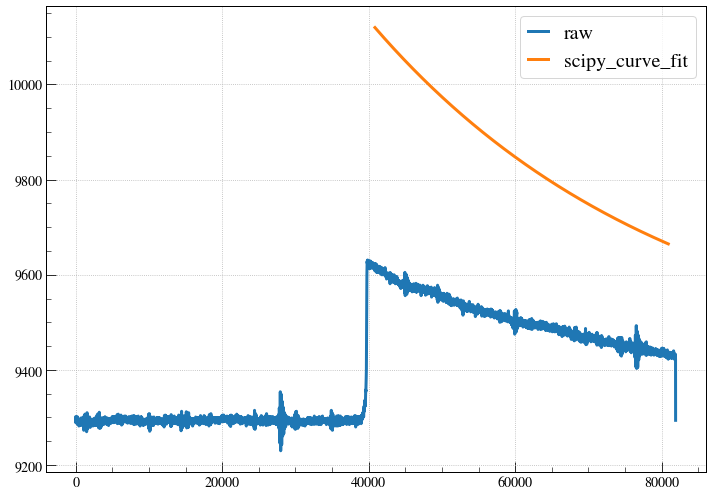

In [ ]:
time = unf.get_time_axis()
wf = df.raw_waveforms[50]
plt.plot(time,wf,label='raw')

def exp_decay_func(x,A,tau,C):
    return A*np.exp(-x/tau)+C

start_index = np.argmax(wf)+100+beginning_padding
end_index = len(wf)-100

wf_to_fit = wf[start_index:end_index]
#time_to_fit = time[start_index:end_index]
time_to_fit = list(range(0,(end_index-start_index)*10, 10))


y = exp_decay_func(np.array(time_to_fit), A, tau, C)
plt.plot(time[start_index:end_index], y, label='scipy_curve_fit')
plt.legend()

In [ ]:
dcr_raw = []
for wf in df.wfs_pz:
    dcr_raw.append(unf.get_dcr_raw(wf))
    
    
df['dcr_raw_pl'] = pd.Series(dcr_raw)

df['dcr_pl'] = df.dcr_raw_pl/df.trapEmax
df

,dsp_file_index,trapEmax,raw_file_index,raw_waveforms,A,tau,C,err_on_A,err_on_tau,err_on_C,wfs_pz,dcr_raw_pl,dcr_pl
75,5,696.724182,5,"[9296, 9308, 9309, 9301, 9287, 9274, 9271, 926...",1463.825516,38898.106064,9519.302527,2.407590,111.860566,2.614635,"[9296.0, 9308.001600600508, 9309.006128236388,...",157.214275,0.225648
2,168,299.905640,168,"[9299, 9294, 9291, 9293, 9303, 9297, 9300, 929...",752.824288,42006.202126,9373.172625,2.730541,255.311713,2.933857,"[9299.0, 9294.000342950978, 9290.999466303883,...",73.095410,0.243728
93,334,857.605042,334,"[9290, 9279, 9282, 9289, 9292, 9304, 9308, 931...",384.893997,38047.966724,9362.313453,2.342288,410.293229,2.552523,"[9290.0, 9278.998063034343, 9281.99344295293, ...",36.305257,0.042333
23,486,273.851990,486,"[9287, 9280, 9290, 9283, 9283, 9288, 9292, 929...",447.503705,40080.963870,9351.265747,2.349128,360.836040,2.538634,"[9287.0, 9280.000055857592, 9289.998404277883,...",41.765714,0.152512
45,520,402.305267,520,"[9299, 9291, 9292, 9296, 9298, 9302, 9300, 929...",241.181199,52256.839895,9276.048049,4.232160,1383.444825,4.439017,"[9299.0, 9290.999921945724, 9291.997892534533,...",19.974482,0.049650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,9592,363.258362,9592,"[9293, 9295, 9290, 9289, 9291, 9293, 9285, 929...",259.040407,39876.268634,9325.524734,2.154954,574.152983,2.334206,"[9293.0, 9294.999890967933, 9290.000269775093,...",18.594786,0.051189
12,9829,587.739197,9829,"[9278, 9273, 9280, 9280, 9282, 9284, 9294, 928...",415.900893,41840.772101,9334.355724,2.484990,420.180571,2.671987,"[9278.0, 9272.997739109096, 9279.99425862012, ...",38.405675,0.065345
39,9861,859.211060,9861,"[9288, 9285, 9293, 9297, 9289, 9298, 9294, 929...",215.870336,30753.293032,9348.011950,1.399642,406.062252,1.584020,"[9288.0, 9284.999630949624, 9292.998530140405,...",14.280723,0.016621
79,9972,855.153381,9972,"[9283, 9280, 9284, 9289, 9289, 9288, 9291, 928...",134.394424,33865.332344,9321.976397,1.699300,822.600332,1.892303,"[9283.0, 9279.999233116732, 9283.997734474622,...",1.924620,0.002251


In [ ]:
dcr = unf.get_dsp_vals(filename, 'dcr', indices=df.dsp_file_index)
df['dcr_dsp'] = dcr.dcr

df

,dsp_file_index,trapEmax,raw_file_index,raw_waveforms,A,tau,C,err_on_A,err_on_tau,err_on_C,wfs_pz,dcr_raw_pl,dcr_pl,dcr_dsp
75,5,696.724182,5,"[9296, 9308, 9309, 9301, 9287, 9274, 9271, 926...",1463.825516,38898.106064,9519.302527,2.407590,111.860566,2.614635,"[9296.0, 9308.001600600508, 9309.006128236388,...",157.214275,0.225648,-3.922604
2,168,299.905640,168,"[9299, 9294, 9291, 9293, 9303, 9297, 9300, 929...",752.824288,42006.202126,9373.172625,2.730541,255.311713,2.933857,"[9299.0, 9294.000342950978, 9290.999466303883,...",73.095410,0.243728,-5.400533
93,334,857.605042,334,"[9290, 9279, 9282, 9289, 9292, 9304, 9308, 931...",384.893997,38047.966724,9362.313453,2.342288,410.293229,2.552523,"[9290.0, 9278.998063034343, 9281.99344295293, ...",36.305257,0.042333,-6.636779
23,486,273.851990,486,"[9287, 9280, 9290, 9283, 9283, 9288, 9292, 929...",447.503705,40080.963870,9351.265747,2.349128,360.836040,2.538634,"[9287.0, 9280.000055857592, 9289.998404277883,...",41.765714,0.152512,-5.194676
45,520,402.305267,520,"[9299, 9291, 9292, 9296, 9298, 9302, 9300, 929...",241.181199,52256.839895,9276.048049,4.232160,1383.444825,4.439017,"[9299.0, 9290.999921945724, 9291.997892534533,...",19.974482,0.049650,-4.127817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,9592,363.258362,9592,"[9293, 9295, 9290, 9289, 9291, 9293, 9285, 929...",259.040407,39876.268634,9325.524734,2.154954,574.152983,2.334206,"[9293.0, 9294.999890967933, 9290.000269775093,...",18.594786,0.051189,-4.417797
12,9829,587.739197,9829,"[9278, 9273, 9280, 9280, 9282, 9284, 9294, 928...",415.900893,41840.772101,9334.355724,2.484990,420.180571,2.671987,"[9278.0, 9272.997739109096, 9279.99425862012, ...",38.405675,0.065345,-2.790067
39,9861,859.211060,9861,"[9288, 9285, 9293, 9297, 9289, 9298, 9294, 929...",215.870336,30753.293032,9348.011950,1.399642,406.062252,1.584020,"[9288.0, 9284.999630949624, 9292.998530140405,...",14.280723,0.016621,-9.605693
79,9972,855.153381,9972,"[9283, 9280, 9284, 9289, 9289, 9288, 9291, 928...",134.394424,33865.332344,9321.976397,1.699300,822.600332,1.892303,"[9283.0, 9279.999233116732, 9283.997734474622,...",1.924620,0.002251,-5.567835


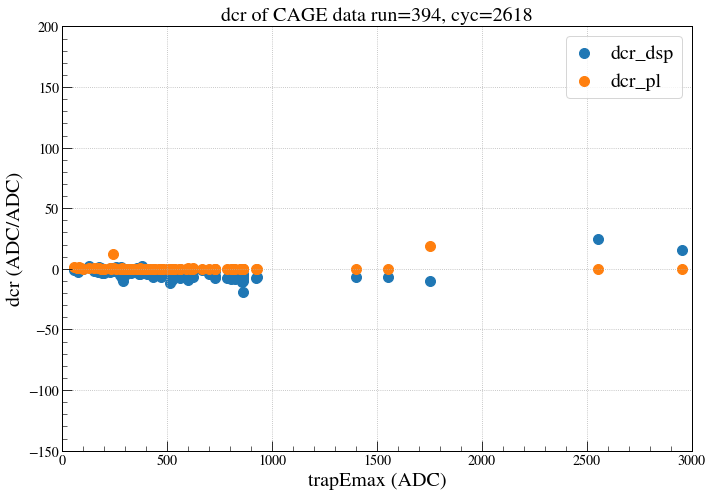

In [ ]:

plt.scatter(df.trapEmax, df.dcr_dsp, label='dcr_dsp')


plt.scatter(df.trapEmax, df.dcr_pl, label='dcr_pl')
plt.xlabel('trapEmax (ADC)')
plt.ylabel('dcr = np.mean(wf_pz_flat[-100:-1]) - np.mean(wf_pz_flat[0:100])?')
plt.title('dcr of CAGE data run=394, cyc=2618, events=[0:100]')
#plt.xlim(0,3000)





plt.xlabel('trapEmax (ADC)')
plt.ylabel('dcr (ADC/ADC)')
plt.title('dcr of CAGE data run=394, cyc=2618')
plt.xlim(0,3000)
plt.ylim(-150,200)
plt.legend()

In [ ]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |███████████████████▊            | 362.5 MB 96.4 MB/s eta 0:00:03

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 588.3 MB 38 kB/s s eta 0:00:01
     |████████████████████████████████| 439 kB 77.7 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 19.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 72.2 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Consider adding this directory to PATH or, if you prefer to suppress this warni